# Data Pre Processing

In [1]:
### Comment Section

#Data Description details link: https://competitions.codalab.org/competitions/11161#learn_the_details-data2

#productCategoryID (serial) productID categoryID
#productID (serial) priceLog2 (log-transformed product price) product.name.tokens (comma separated hashed product name tokens) imageName (name of the corresponding product image)

#train-purchases.csv 
#sessionId (serial) timeframe (time since the first query in a session, in milliseconds) eventdate (calendar date) ordernumber (serial product orderID; groups all products purchased together ~ shopping cart; if a user bought several products, there are several records sharing the same ordernumber) itemId (purchased product)

#train-item-views
#sessionId userId itemId timeframe (time since the first query in a session, in milliseconds) eventdate (calendar date)

#train_data
#queryId (serial) sessionId (serial) userId (serial) timeframe (time since the first query in a session, in milliseconds) duration (page dwell time, in milliseconds) eventdate (calendar date) searchstring.tokens (comma separated hashed query tokens; empty if it is a query-less case) categoryId (product category ID; empty if it is a query-full session) items (productIDs returned by the default ranking algorithm on the SERP; this IDs must be re-ranked).

In [2]:
### possible features
# UserId-> Range of Cost
# Item rating? ->Based on purchases. Assumption more purchases, better rating
# Ranking of items -> on a scale of 1-0. Shouldn't it be based on queryId, SessionId and then items?

In [1]:
import os
import pandas as pd
import time
import numpy as np
from matplotlib import pyplot as plt

In [64]:
start = time. time()
#parent_path_to_data
path_to_data= "D:\Courses\InfoStorage\Project\Data\Data-20190409T171847Z-001\Data"
#TO DO: Code refractor get os.cwd() and choose relative path.

product_categories= pd.read_csv(path_to_data+"\product-categories.csv",delimiter=";")

products= pd.read_csv(path_to_data+"\products.csv",delimiter=";")
#Last Value in the list is actually the imageName
products['imageName'] = products['product.name.tokens'].apply(lambda x: x.split(',')[-1])
#Take out the last value as it is not a product name token
products['product.name.tokens']=products['product.name.tokens'].apply(lambda x: x.split(',')[:-1])

train_purchases= pd.read_csv(path_to_data+"\\train-purchases.csv",delimiter=";")
#This data is against the format given there is a User ID with value NaN
train_item_views= pd.read_csv(path_to_data+"\\train-item-views.csv",delimiter=";")
#Some User Ids have a Value NaN

train_clicks= pd.read_csv(path_to_data+"\\train-clicks.csv",delimiter=";")
#QueryId TimeFrame ItemId

combined_data= pd.read_csv(path_to_data+"\\train-queries.csv",delimiter=";")
end = time. time()
print("Data read took: %f seconds " % (end-start))

Data read took: 15.948879 seconds 


D:\Courses\InfoStorage\Anaconda\envs\cs670\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [65]:
products.head()

,itemId,pricelog2,product.name.tokens,imageName
0,1,10,"[4875, 776, 56689, 18212, 18212]",4896
1,69585,6,"[7583, 18117, 41805, 41805]",2371
2,90939,6,"[604, 18117, 41805, 41805]",2371
3,69586,0,"[2936, 18117, 41805, 41805]",2371
4,30029,7,"[4668, 41805, 41805]",56652


In [66]:
product_categories.head()

,itemId,categoryId
0,139578,1096
1,417975,1096
2,291805,1096
3,396921,1096
4,159257,1096


In [67]:
#Convert the date to the date format
combined_data['eventdate'] = pd.to_datetime(combined_data["eventdate"])

#We focus only on query-full queries
combined_data = combined_data[~combined_data["searchstring.tokens"].isnull()]

In [68]:
combined_data.head()

,queryId,sessionId,userId,timeframe,duration,eventdate,searchstring.tokens,categoryId,items,is.test
0,1,1,NaN,16327074,311,2016-05-09,"16655,244087,51531,529597,58153",0,"7518,71,30311,7837,30792,8252,81766,9338,62220...",False
1,2,2,NaN,705527,314,2016-05-09,"528941,529116",0,"70095,15964,8627,134850,32754,100747,74771,314...",False
2,3,3,NaN,0,502,2016-05-09,"133713,16655,138389",0,"59081,51125,9338,9550,32087,62793,2717,10403,3...",True
3,4,4,NaN,0,1092,2016-05-09,"3918,3822,460416,528812,5276,529517,528738",0,"46632,57465,79064,57748,6080,35997,47088,6078,...",False
4,5,5,NaN,102700,266,2016-05-09,"529223,199482",0,"27312,84626,12621,46209,5140,57539,5368,12923,...",False


In [7]:
# Split QueryId-> item1,item2,item3 into 1:1 mapping 
# These are items that appeared after the query result
query_item = []
for session,query,items,userId in combined_data[["sessionId","queryId", "items","userId"]].values:
    items = map(np.int64,items.split(','))
    for i in items:
        query_item.append( (session,query,i,userId) )
query_item = pd.DataFrame().from_records(query_item, columns=["sessionId","queryId","itemId","userId"])

In [8]:
train_item_views.head()

,sessionId,userId,itemId,timeframe,eventdate
0,1,NaN,81766,526309,2016-05-09
1,1,NaN,31331,1031018,2016-05-09
2,1,NaN,32118,243569,2016-05-09
3,1,NaN,9654,75848,2016-05-09
4,1,NaN,32627,1112408,2016-05-09


In [9]:
train_item_views['eventdate'] = pd.to_datetime(train_item_views["eventdate"])
train_item_views.sort_values(["sessionId", "userId", "eventdate", "timeframe", "itemId"], inplace=True)
train_item_views= train_item_views.reset_index(drop=True)

In [10]:
train_item_views.head()

,sessionId,userId,itemId,timeframe,eventdate
0,1,NaN,9654,75848,2016-05-09
1,1,NaN,33043,173912,2016-05-09
2,1,NaN,32118,243569,2016-05-09
3,1,NaN,12352,329870,2016-05-09
4,1,NaN,35077,390072,2016-05-09


In [11]:
train_clicks.sort_values(["queryId", "timeframe", "itemId"], inplace=True)
train_clicks= train_clicks.reset_index(drop=True)

In [12]:
train_clicks.head() #what is time frame wrt to this?

,queryId,timeframe,itemId
0,1,16338861,24857
1,2,721764,36246
2,4,20684,13931
3,5,118873,35472
4,6,52095,73191


In [13]:
train_purchases.head() # timeframe - time since the first query in a session, in milliseconds

,sessionId,userId,timeframe,eventdate,ordernumber,itemId
0,150,18278.0,17100868,2016-05-06,16421,25911
1,151,NaN,6454547,2016-05-06,16290,175874
2,156,7.0,1721689387,2016-05-27,21173,35324
3,179,NaN,343001,2016-05-09,16924,31233
4,246,34.0,2311046,2016-05-09,16936,34677


In [14]:
train_purchases.sort_values(["sessionId", "userId", "eventdate", "timeframe", "itemId", "ordernumber"], inplace=True)
train_purchases= train_purchases.reset_index(drop=True)

In [69]:
Train_data= combined_data.loc[combined_data['is.test']==False]
Test_data= combined_data.loc[combined_data['is.test']==True]

In [16]:
combined_data.loc[combined_data['sessionId']==19036][combined_data['queryId']==23402]

D:\Courses\InfoStorage\Anaconda\envs\cs670\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,queryId,sessionId,userId,timeframe,duration,eventdate,searchstring.tokens,categoryId,items,is.test
23395,23402,19036,16133.0,0,327,2016-03-11,"539617,533607,67941",0,"15157,51250,1981,16556,134626,62710,22235,3215...",False


In [17]:
train_clicks.loc[train_clicks['queryId']==23402]

,queryId,timeframe,itemId
16280,23402,10023,128150


In [18]:
train_item_views.loc[train_item_views['sessionId']==19036]

,sessionId,userId,itemId,timeframe,eventdate
47160,19036,16133.0,128150,11991,2016-03-11
47161,19036,16133.0,128150,61271,2016-03-11
47162,19036,16133.0,128150,97473,2016-03-11
47163,19036,16133.0,128150,104783,2016-03-11
47164,19036,16133.0,128150,117216,2016-03-11
47165,19036,16133.0,128150,149375,2016-03-11


In [19]:
#Some stats
#Number of Unique Sessions in the Test_+Train = 40345
#Number of Unique Sessions in the Test+Train(after removing NaN) = 18356
#Number of Unique Users in the Train+Test= 18113

In [20]:
print("Number of Unique Sessions in the Test+Train=",len(query_item['sessionId'].unique()))

Number of Unique Sessions in the Test+Train= 40345


In [21]:
temp=combined_data
temp = temp[np.isfinite(temp['userId'])] #Drop all rows who's UserID is NAN
print("Number of Unique Users in the Train+Test=", len(temp['userId'].unique()))
L=[]
for region,df_region in temp.groupby('sessionId'):
    L.append(len(df_region['queryId']))

Number of Unique Users in the Train+Test= 18113


In [22]:
print(L)

In [23]:
testing=pd.DataFrame()
i=0
for region,df_region in temp.groupby('sessionId'):
    if i == 0:
        testing=df_region
        break
    i=i+1

In [24]:
testing.head()

,queryId,sessionId,userId,timeframe,duration,eventdate,searchstring.tokens,categoryId,items,is.test
47,48,48,2.0,0,616,2016-04-09,"664,1075,528697,451492,528766,296114",0,"35389,68366,35438,5472,5683,24764,35627,46907,...",False


In [27]:
#train_item_views.loc[train_item_views['sessionId']==48]

In [28]:
#train_clicks.loc[train_clicks['queryId']==48]

In [44]:
testing.head()

,queryId,sessionId,userId,timeframe,duration,eventdate,searchstring.tokens,categoryId,items,is.test
107,108,107,5.0,267190,485,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False
34085,34092,107,5.0,293331,302,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False
34309,34316,107,5.0,236597,221,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False
34391,34398,107,5.0,314229,114,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False
34461,34468,107,5.0,192070,175,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False


In [29]:
#combined_data.loc[combined_data['queryId']==980493]

In [30]:
print("Number of Unique Sessions in the Test+Train=",len(temp['sessionId'].unique()))

Number of Unique Sessions in the Test+Train= 18356


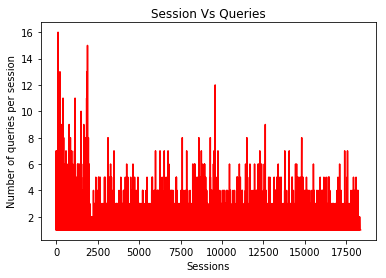

In [31]:
from matplotlib import pyplot as plt
plt.plot(L,'r')
plt.xlabel("Sessions")
plt.ylabel("Number of queries per session")
plt.title("Session Vs Queries")
plt.show()

In [32]:
print(np.mean(L))

1.2664523861407715


In [38]:
train_users = Train_data['userId'].unique().tolist()
test_users = Test_data['userId'].unique().tolist()

In [45]:
print("Number of Unique users in Train ",len(train_users))
print("Number of Unique users in Test ",len(test_users))

Number of Unique users in Train  11676
Number of Unique users in Test  7831


In [40]:
print("Number of Users present in both Train and Test", len(list(set(train_users) & set(test_users))))

Number of Users present in both Train and Test 1392


In [42]:
train_users.sort()
test_users.sort()
print(train_users[:20])
print(test_users[:20])

[nan, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 20.0, 23.0, 24.0, 25.0]
[nan, 4.0, 8.0, 12.0, 18.0, 19.0, 21.0, 22.0, 23.0, 24.0, 25.0, 28.0, 30.0, 31.0, 37.0, 38.0, 39.0, 41.0, 43.0, 45.0]


In [47]:
temp = Train_data[np.isfinite(Train_data['userId'])]
print("% of Nan Users in Train", (len(Train_data)/len(temp)))
temp = Test_data[np.isfinite(Test_data['userId'])]
print("% of Nan Users in Test", (len(Test_data)/len(temp)))

% of Nan Users in Train 2.317779513210985
% of Nan Users in Test 2.0648394873746985


In [48]:
users_who_made_purchases=train_purchases['userId'].unique().tolist()
print("Number of Unique users who made at least one purchase ",len(users_who_made_purchases))

Number of Unique users who made at least one purchase  4426


In [50]:
users_who_made_purchases.sort()
print("Number of Users present Train and made a purchase", len(list(set(train_users) & set(users_who_made_purchases))))

Number of Users present Train and made a purchase 619


In [59]:
users_who_viewed_items = train_item_views[np.isfinite(train_item_views['userId'])]['userId'].unique().tolist()
print("Total Number of users who viewed something",len(train_item_views[np.isfinite(train_item_views['userId'])]))
print("Total Number of unique users who viewed some item",len(users_who_viewed_items))

Total Number of users who viewed something 372991
Total Number of unique users who viewed some item 87934


In [61]:
print("Number of users who viewed something and is present in the Train",len(list(set(users_who_viewed_items) & set(train_users))))
print("Number of users who viewed something and is present in the Test",len(list(set(users_who_viewed_items) & set(test_users))))

Number of users who viewed something and is present in the Train 11401
Number of users who viewed something and is present in the Test 1971


In [62]:
interection_users_present_in_test_train=list(set(train_users) & set(test_users))
print("Number of users in Train and Test who viewed atleast one item",len(list(set(users_who_viewed_items) & set(interection_users_present_in_test_train))))

Number of users in Train and Test who viewed atleast one item 1354


In [64]:
#Clicks are wrt Query ID
train_clicks.head()

,queryId,timeframe,itemId
0,1,16338861,24857
1,2,721764,36246
2,4,20684,13931
3,5,118873,35472
4,6,52095,73191


In [101]:
user_Id_queryId_item_clicked_df = pd.merge(combined_data[['userId','queryId',]],train_clicks,how='inner',on=['queryId'])

In [102]:
temp=user_Id_queryId_item_clicked_df['userId'].unique().tolist()
temp.sort()
print("Number of Users who clicked something in the union Train+Test",len(temp))

Number of Users who clicked something in the union Train+Test 11672


In [103]:
print("Number of users who clicked at least once item and is present in the Train",len(list(set(temp) & set(train_users))))
print("Number of users who clicked at least once item and is present in the Test",len(list(set(temp) & set(test_users))))
print("Number of users who clicked at least once item and is present in the intersection of Test and Train",len(list(set(temp) & set(interection_users_present_in_test_train))))

Number of users who clicked at least once item and is present in the Train 11671
Number of users who clicked at least once item and is present in the Test 1392
Number of users who clicked at least once item and is present in the intersection of Test and Train 1392


In [104]:
#Users who have trained, clicked,viewed and purchased
full_users_intersection = list(set(train_users) & set(temp) & set(users_who_made_purchases) & set(users_who_viewed_items) )

In [105]:
print(len(full_users_intersection))

590


In [106]:
full_users_intersection.sort()
print(full_users_intersection[:20])

[3.0, 7.0, 80.0, 87.0, 113.0, 177.0, 197.0, 232.0, 244.0, 245.0, 352.0, 358.0, 368.0, 413.0, 444.0, 447.0, 489.0, 494.0, 531.0, 548.0]


In [107]:
user_Id_intersection_df={}
for user in full_users_intersection:
    L=[]
    L.append(user_Id_queryId_item_clicked_df[user_Id_queryId_item_clicked_df['userId'] == user])
    L.append(train_item_views[train_item_views['userId'] == user])
    L.append(train_purchases[train_purchases['userId'] == user])
    user_Id_intersection_df[user]=L

In [108]:
get = user_Id_intersection_df.get(3.0)

In [111]:
print(get[0])

       userId  queryId  timeframe  itemId
40        3.0       60      71214   22128
33950     3.0    48115    1663359    7018


In [116]:
print(get[1])

         sessionId  userId  itemId  timeframe  eventdate
194             60     3.0   22128      22704 2016-05-09
195             60     3.0   22128      71762 2016-05-09
97188        37537     3.0   36885      13938 2016-05-22
97189        37537     3.0  375756     113908 2016-05-22
97190        37537     3.0  375973     151800 2016-05-22
97191        37537     3.0    7005     185748 2016-05-22
97192        37537     3.0  376984     212022 2016-05-22
97193        37537     3.0  376427     242938 2016-05-22
97194        37537     3.0   36885     278342 2016-05-22
526859      176952     3.0  135286     128763 2016-04-16
526860      176952     3.0  115071     212273 2016-04-16
526861      176952     3.0   38873     240686 2016-04-16
526862      176952     3.0   35932     266040 2016-04-16
805920      296261     3.0   10349      16974 2016-05-14
805921      296261     3.0   12233      97009 2016-05-14
805922      296261     3.0   30378     216052 2016-05-14
805923      296261     3.0   10

In [113]:
print(get[2])

       sessionId  userId  timeframe   eventdate  ordernumber  itemId
13957     368274     3.0    3318366  2016-02-17         2081   47089


In [114]:
userId_query_Id.get(3.0)

,queryId,sessionId,userId,timeframe,duration,eventdate,searchstring.tokens,categoryId,items,is.test
59,60,60,3.0,63912,1486,2016-05-09,"16655,186788,105959",0,"21100,113639,22128,2444,52938,129975,17247,329...",False
48108,48115,37537,3.0,1654797,432,2016-05-22,"486262,537336,105363",0,"69238,14519,7018,7017,126514,7015,14526,14525,...",False


In [88]:

#Number of Queries Given By a user Across Sessions
number_of_queries_per_user_across_sessions_train=[]
userId_query_Id={}
for user in train_users[1:]:
    userId_query_Id[user] = Train_data[Train_data['userId'] == user]
    number_of_queries_per_user_across_sessions_train.append(len(Train_data[Train_data['userId'] == user]['queryId']))

In [92]:
print(train_users[1:20])

[2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 20.0, 23.0, 24.0, 25.0]


In [93]:
print(number_of_queries_per_user_across_sessions_train[:20])

[1, 2, 7, 2, 1, 1, 2, 4, 1, 1, 1, 3, 3, 3, 2, 2, 1, 1, 2, 2]


In [94]:
userId_query_Id.get(5.0)

,queryId,sessionId,userId,timeframe,duration,eventdate,searchstring.tokens,categoryId,items,is.test
107,108,107,5.0,267190,485,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False
34085,34092,107,5.0,293331,302,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False
34309,34316,107,5.0,236597,221,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False
34391,34398,107,5.0,314229,114,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False
34461,34468,107,5.0,192070,175,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False
34537,34544,107,5.0,78670,576,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False
53398,53424,107,5.0,0,232,2016-04-09,529895,0,"666,38247,8138,8619,32979,85571,33070,85771,10...",False


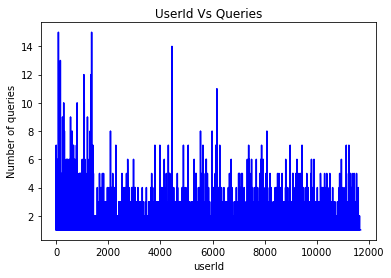

In [84]:
plt.plot(number_of_queries_per_user_across_sessions_train,'b')
plt.xlabel("userId")
plt.ylabel("Number of queries")
plt.title("UserId Vs Queries")
plt.show()

In [86]:
print("Number of Queries per user across all sessions",np.mean(number_of_queries_per_user_across_sessions_train))

Number of Queries per user across all sessions 1.3161456102783726


# Feature Engineering

In [ ]:
# Data Implications
# There are only 1392 users that exist in both our Train and Test Data
# 82% of our users will be first time users
# 2% of both Train and Test data have Users NaNs
# Out of 11676 users in Train only 619 entries would have made purchases
# Out of 11676 users 11401 Users have viewed atleast one item
# Out of the 7831 Test Users 1971 have viewed some items
# Out of 1392 users in the intersection of users in Train and Test 1354 users have viewed an item
# All users who are present in the intersection of Train and Test clicked at least once item

# PICKLE Objects 

In [5]:
pickle_path="D:\\Courses\\InfoStorage\\Project\\Data\\FE\\FeaturePickle"

In [6]:
item_stats= pd.read_pickle(pickle_path+"\\product_stats.pkl")
queries_input= pd.read_pickle(pickle_path+"\\queries_input.pkl")
query_item = pd.read_pickle(pickle_path+"\\query_item.pkl")

In [7]:
item_stats.head()

,itemId,item_show_count,Item_clicks,Item_view_count,Item_purchase_count,userShow,userView,userPurchase,CTR,View Rate,Click Value Rate,vector_gensim_product
0,1,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0075825127, 0.0077215955, -0.0076009654, 0...."
1,2,3.0,36.0,41.0,2.0,2.0,1.0,1.0,12.0,13.666667,0.666667,"[0.002787637, 0.0003684413, -0.007916889, -0.0..."
2,3,NaN,34.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0016407266, -0.009007929, 0.009244843, 0.00..."
3,4,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.007388427, -0.0066472264, 0.0064146067, 0.0..."
4,6,1.0,13.0,9.0,NaN,1.0,1.0,1.0,13.0,9.000000,NaN,"[0.004354867, 0.0013623534, -0.008957111, -0.0..."


In [8]:
#Modifications 
# Make Viewrate,USerPurchase NaN as 0
# Remove User View column. Make UserShow NaN as 0
# tem_show_count	Item_clicks	Item_view_count	Item_purchase_count	 Nans is 0

item_stats= item_stats.drop(['userView'], axis=1)
item_stats.fillna(value=0, inplace=True)

In [9]:
queries_input.head()

,queryId,items
0,1,"7518,71,30311,7837,30792,8252,81766,9338,62220..."
1,2,"70095,15964,8627,134850,32754,100747,74771,314..."
2,3,"59081,51125,9338,9550,32087,62793,2717,10403,3..."
3,4,"46632,57465,79064,57748,6080,35997,47088,6078,..."
4,5,"27312,84626,12621,46209,5140,57539,5368,12923,..."


In [10]:
query_item.head()

,queryId,itemId,vector_gensim_query,Relevance,is.test
0,1,7518,"[-0.006535598, 0.0024064586, 0.0074732024, -0....",0,False
1,1,71,"[-0.006535598, 0.0024064586, 0.0074732024, -0....",0,False
2,1,30311,"[-0.006535598, 0.0024064586, 0.0074732024, -0....",0,False
3,1,7837,"[-0.006535598, 0.0024064586, 0.0074732024, -0....",0,False
4,1,30792,"[-0.006535598, 0.0024064586, 0.0074732024, -0....",0,False


In [11]:
query_item['itemId'].isin(item_stats['itemId']).value_counts()

True    1017762
Name: itemId, dtype: int64

In [12]:
# Keep all rows in the query_item column and append on the matching itemid of the item_stats
# If a query Id does not have a matching itemId in the item_stats fill NaN
# Nevermind All exist
X = pd.merge(query_item,item_stats,on='itemId',how='left')

In [13]:
X.head()

,queryId,itemId,vector_gensim_query,Relevance,is.test,item_show_count,Item_clicks,Item_view_count,Item_purchase_count,userShow,userPurchase,CTR,View Rate,Click Value Rate,vector_gensim_product
0,1,7518,"[-0.006535598, 0.0024064586, 0.0074732024, -0....",0,False,148.0,70.0,57.0,0.0,47.0,1.0,0.472973,0.385135,0.000000,"[0.009888342, 0.006329806, 0.0005410195, -0.00..."
1,1,71,"[-0.006535598, 0.0024064586, 0.0074732024, -0....",0,False,192.0,92.0,73.0,2.0,102.0,1.0,0.479167,0.380208,0.010417,"[-0.0083958395, -0.0075500184, 0.0025241065, 0..."
2,1,30311,"[-0.006535598, 0.0024064586, 0.0074732024, -0....",0,False,108.0,164.0,116.0,2.0,37.0,1.0,1.518519,1.074074,0.018519,"[0.007938938, 0.005018753, 0.0023497294, 0.001..."
3,1,7837,"[-0.006535598, 0.0024064586, 0.0074732024, -0....",0,False,281.0,220.0,191.0,3.0,82.0,1.0,0.782918,0.679715,0.010676,"[-0.0075791064, -0.005229415, 0.008466356, -0...."
4,1,30792,"[-0.006535598, 0.0024064586, 0.0074732024, -0....",0,False,389.0,475.0,445.0,11.0,143.0,1.0,1.221080,1.143959,0.028278,"[-0.0057816627, 0.009380997, 0.00030535308, -0..."


In [14]:
# Split on Test and Train
Train = X[X['is.test']==False]
Test = X[X['is.test']== True]

In [15]:
Train= Train.drop(['is.test'], axis=1)
Test= Test.drop(['is.test'], axis=1)

In [30]:
Test.head()

,queryId,itemId,vector_gensim_query,Relevance,item_show_count,Item_clicks,Item_view_count,Item_purchase_count,userShow,userPurchase,CTR,View Rate,Click Value Rate,vector_gensim_product
42,3,59081,"[-0.00045727068, -0.00245887, -0.009570002, 0....",0,374.0,29.0,23.0,2.0,41.0,1.0,0.077540,0.061497,0.005348,"[-0.0056795957, 0.0066146906, -0.0044425414, 0..."
43,3,51125,"[-0.00045727068, -0.00245887, -0.009570002, 0....",0,2378.0,104.0,96.0,1.0,1113.0,2.0,0.043734,0.040370,0.000421,"[-0.0039685355, 0.003466247, -0.0091299005, 0...."
44,3,9338,"[-0.00045727068, -0.00245887, -0.009570002, 0....",0,2486.0,286.0,274.0,4.0,865.0,1.0,0.115044,0.110217,0.001609,"[0.0093724625, -0.0019690525, -0.007802633, 0...."
45,3,9550,"[-0.00045727068, -0.00245887, -0.009570002, 0....",0,291.0,152.0,126.0,1.0,74.0,1.0,0.522337,0.432990,0.003436,"[0.0037035453, -0.003637445, -0.0018692636, -0..."
46,3,32087,"[-0.00045727068, -0.00245887, -0.009570002, 0....",0,92.0,44.0,43.0,2.0,17.0,1.0,0.478261,0.467391,0.021739,"[-0.0007508087, 0.0017219065, 0.0040693423, -0..."


In [16]:
test=[]
query_item_order_test=[]
labels_test=[]
for index,row in Test.iterrows():
    r=[]
    query_item_order_test.append([row['queryId'],row['itemId']])
    
    r.append(row['item_show_count'])
    r.append(row['Item_clicks'])
    r.append(row['Item_view_count'])
    r.append(row['Item_purchase_count'])
    r.append(row['CTR'])
    r.append(row['View Rate'])
    r.append(row['Click Value Rate'])
    r.append(row['View Rate'])
    r= r + row['vector_gensim_query'].tolist()
    r= r + row['vector_gensim_product'].tolist()
    
    test.append(r)
    labels_test.append(row['Relevance'])

In [17]:
train=[]
query_item_order=[]
labels=[]
for index,row in Train.iterrows():
    r=[]
    query_item_order.append([row['queryId'],row['itemId']])
    
    r.append(row['item_show_count'])
    r.append(row['Item_clicks'])
    r.append(row['Item_view_count'])
    r.append(row['Item_purchase_count'])
    r.append(row['CTR'])
    r.append(row['View Rate'])
    r.append(row['Click Value Rate'])
    r.append(row['View Rate'])
    r= r + row['vector_gensim_query'].tolist()
    r= r + row['vector_gensim_product'].tolist()
    
    train.append(r)
    labels.append(row['Relevance'])

In [18]:
train = np.array(train)
train.shape

(703519, 108)

In [19]:
test= np.array(test)
test.shape

(314243, 108)

# Data is Prepared, Lets do pairwise transform now

In [39]:
import itertools
import numpy as np
from scipy import stats
import pylab as pl
from sklearn import svm, linear_model
from sklearn.model_selection import cross_validate
from collections import OrderedDict
from scipy import linalg

In [21]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train = sc.fit_transform(train)
test = sc.transform(test)

In [22]:
L=Train['queryId'].value_counts(sort=True, ascending=True)

In [23]:
L = dict(L)
L= OrderedDict(sorted(L.items()))

In [24]:
len(L)

35615

In [25]:
len(labels)

703519

In [26]:
#http://fa.bianp.net/blog/2012/learning-to-rank-with-scikit-learn-the-pairwise-transform/
k = 0
Xp, yp, diff = [], [], []
s=0
e=0
theta = np.deg2rad(60)
w = np.array([np.sin(theta), np.cos(theta)]) #for plotting
for key in L:
    comb = itertools.combinations(range(L.get(key)), 2)
    #create the first batch
    s=e
    e=s+L.get(key) -1
    print("Start:%d, End %d" %(s,e))
    for (i, j) in comb:
        i=i+s
        j=j+e-1
        if labels[i] == labels[j] or query_item_order[i][0] != query_item_order[j][0] :
            # skip if same target or different group(different qIds)
            continue
        Xp.append(train[i] - train[j])
        diff.append(labels[i] - labels[j])
        yp.append(np.sign(diff[-1]))
        # output balanced classes
        if yp[-1] != (-1) ** k:
            yp[-1] *= -1
            Xp[-1] *= -1
            diff[-1] *= -1
        k += 1
Xp, yp, diff = map(np.asanyarray, (Xp, yp, diff))

Start:0, End 19
Start:19, End 40
Start:40, End 59
Start:59, End 78
Start:78, End 96
Start:96, End 118
Start:118, End 136
Start:136, End 155
Start:155, End 174
Start:174, End 193
Start:193, End 212
Start:212, End 231
Start:231, End 250
Start:250, End 271
Start:271, End 289
Start:289, End 309
Start:309, End 330
Start:330, End 352
Start:352, End 371
Start:371, End 390
Start:390, End 409
Start:409, End 432
Start:432, End 451
Start:451, End 470
Start:470, End 489
Start:489, End 508
Start:508, End 527
Start:527, End 546
Start:546, End 565
Start:565, End 584
Start:584, End 607
Start:607, End 625
Start:625, End 646
Start:646, End 665
Start:665, End 684
Start:684, End 703
Start:703, End 722
Start:722, End 742
Start:742, End 762
Start:762, End 780
Start:780, End 801
Start:801, End 815
Start:815, End 834
Start:834, End 854
Start:854, End 872
Start:872, End 891
Start:891, End 913
Start:913, End 932
Start:932, End 952
Start:952, End 970
Start:970, End 989
Start:989, End 1008
Start:1008, End 1027
St

Start:15550, End 15569
Start:15569, End 15579
Start:15579, End 15596
Start:15596, End 15615
Start:15615, End 15634
Start:15634, End 15655
Start:15655, End 15674
Start:15674, End 15693
Start:15693, End 15713
Start:15713, End 15733
Start:15733, End 15752
Start:15752, End 15771
Start:15771, End 15790
Start:15790, End 15809
Start:15809, End 15828
Start:15828, End 15847
Start:15847, End 15866
Start:15866, End 15885
Start:15885, End 15904
Start:15904, End 15924
Start:15924, End 15943
Start:15943, End 15962
Start:15962, End 15981
Start:15981, End 16001
Start:16001, End 16020
Start:16020, End 16039
Start:16039, End 16058
Start:16058, End 16072
Start:16072, End 16091
Start:16091, End 16110
Start:16110, End 16129
Start:16129, End 16148
Start:16148, End 16160
Start:16160, End 16179
Start:16179, End 16199
Start:16199, End 16219
Start:16219, End 16238
Start:16238, End 16258
Start:16258, End 16277
Start:16277, End 16296
Start:16296, End 16315
Start:16315, End 16334
Start:16334, End 16353
Start:16353

Start:31254, End 31274
Start:31274, End 31293
Start:31293, End 31312
Start:31312, End 31331
Start:31331, End 31350
Start:31350, End 31362
Start:31362, End 31384
Start:31384, End 31404
Start:31404, End 31421
Start:31421, End 31440
Start:31440, End 31459
Start:31459, End 31479
Start:31479, End 31497
Start:31497, End 31516
Start:31516, End 31535
Start:31535, End 31554
Start:31554, End 31573
Start:31573, End 31594
Start:31594, End 31609
Start:31609, End 31619
Start:31619, End 31639
Start:31639, End 31658
Start:31658, End 31677
Start:31677, End 31687
Start:31687, End 31700
Start:31700, End 31719
Start:31719, End 31739
Start:31739, End 31758
Start:31758, End 31774
Start:31774, End 31793
Start:31793, End 31812
Start:31812, End 31831
Start:31831, End 31850
Start:31850, End 31869
Start:31869, End 31888
Start:31888, End 31907
Start:31907, End 31926
Start:31926, End 31945
Start:31945, End 31964
Start:31964, End 31983
Start:31983, End 32010
Start:32010, End 32029
Start:32029, End 32048
Start:32048

Start:42823, End 42849
Start:42849, End 42868
Start:42868, End 42884
Start:42884, End 42904
Start:42904, End 42923
Start:42923, End 42942
Start:42942, End 42962
Start:42962, End 42982
Start:42982, End 43001
Start:43001, End 43021
Start:43021, End 43041
Start:43041, End 43062
Start:43062, End 43082
Start:43082, End 43102
Start:43102, End 43124
Start:43124, End 43144
Start:43144, End 43163
Start:43163, End 43177
Start:43177, End 43196
Start:43196, End 43215
Start:43215, End 43235
Start:43235, End 43250
Start:43250, End 43269
Start:43269, End 43288
Start:43288, End 43310
Start:43310, End 43329
Start:43329, End 43349
Start:43349, End 43371
Start:43371, End 43394
Start:43394, End 43413
Start:43413, End 43433
Start:43433, End 43451
Start:43451, End 43475
Start:43475, End 43494
Start:43494, End 43509
Start:43509, End 43528
Start:43528, End 43547
Start:43547, End 43565
Start:43565, End 43584
Start:43584, End 43603
Start:43603, End 43624
Start:43624, End 43643
Start:43643, End 43662
Start:43662

Start:53298, End 53317
Start:53317, End 53336
Start:53336, End 53355
Start:53355, End 53375
Start:53375, End 53394
Start:53394, End 53413
Start:53413, End 53438
Start:53438, End 53457
Start:53457, End 53476
Start:53476, End 53495
Start:53495, End 53514
Start:53514, End 53534
Start:53534, End 53553
Start:53553, End 53572
Start:53572, End 53590
Start:53590, End 53609
Start:53609, End 53628
Start:53628, End 53648
Start:53648, End 53667
Start:53667, End 53689
Start:53689, End 53708
Start:53708, End 53733
Start:53733, End 53752
Start:53752, End 53774
Start:53774, End 53793
Start:53793, End 53812
Start:53812, End 53830
Start:53830, End 53849
Start:53849, End 53868
Start:53868, End 53890
Start:53890, End 53908
Start:53908, End 53927
Start:53927, End 53946
Start:53946, End 53964
Start:53964, End 53982
Start:53982, End 54004
Start:54004, End 54023
Start:54023, End 54045
Start:54045, End 54064
Start:54064, End 54083
Start:54083, End 54102
Start:54102, End 54121
Start:54121, End 54145
Start:54145

Start:66971, End 66990
Start:66990, End 67009
Start:67009, End 67028
Start:67028, End 67037
Start:67037, End 67057
Start:67057, End 67076
Start:67076, End 67097
Start:67097, End 67116
Start:67116, End 67134
Start:67134, End 67153
Start:67153, End 67172
Start:67172, End 67181
Start:67181, End 67200
Start:67200, End 67219
Start:67219, End 67231
Start:67231, End 67250
Start:67250, End 67269
Start:67269, End 67288
Start:67288, End 67307
Start:67307, End 67317
Start:67317, End 67336
Start:67336, End 67357
Start:67357, End 67376
Start:67376, End 67395
Start:67395, End 67414
Start:67414, End 67433
Start:67433, End 67452
Start:67452, End 67463
Start:67463, End 67482
Start:67482, End 67501
Start:67501, End 67521
Start:67521, End 67540
Start:67540, End 67551
Start:67551, End 67570
Start:67570, End 67591
Start:67591, End 67610
Start:67610, End 67621
Start:67621, End 67643
Start:67643, End 67662
Start:67662, End 67681
Start:67681, End 67700
Start:67700, End 67720
Start:67720, End 67739
Start:67739

Start:80307, End 80326
Start:80326, End 80348
Start:80348, End 80367
Start:80367, End 80385
Start:80385, End 80404
Start:80404, End 80423
Start:80423, End 80442
Start:80442, End 80461
Start:80461, End 80480
Start:80480, End 80499
Start:80499, End 80518
Start:80518, End 80538
Start:80538, End 80557
Start:80557, End 80578
Start:80578, End 80600
Start:80600, End 80619
Start:80619, End 80638
Start:80638, End 80657
Start:80657, End 80679
Start:80679, End 80698
Start:80698, End 80711
Start:80711, End 80732
Start:80732, End 80751
Start:80751, End 80765
Start:80765, End 80784
Start:80784, End 80805
Start:80805, End 80824
Start:80824, End 80846
Start:80846, End 80865
Start:80865, End 80884
Start:80884, End 80903
Start:80903, End 80922
Start:80922, End 80941
Start:80941, End 80961
Start:80961, End 80980
Start:80980, End 80999
Start:80999, End 81017
Start:81017, End 81037
Start:81037, End 81055
Start:81055, End 81074
Start:81074, End 81093
Start:81093, End 81114
Start:81114, End 81133
Start:81133

Start:93582, End 93601
Start:93601, End 93620
Start:93620, End 93639
Start:93639, End 93652
Start:93652, End 93671
Start:93671, End 93691
Start:93691, End 93709
Start:93709, End 93720
Start:93720, End 93739
Start:93739, End 93758
Start:93758, End 93777
Start:93777, End 93797
Start:93797, End 93806
Start:93806, End 93816
Start:93816, End 93826
Start:93826, End 93845
Start:93845, End 93864
Start:93864, End 93882
Start:93882, End 93901
Start:93901, End 93920
Start:93920, End 93940
Start:93940, End 93959
Start:93959, End 93974
Start:93974, End 93993
Start:93993, End 94013
Start:94013, End 94032
Start:94032, End 94051
Start:94051, End 94070
Start:94070, End 94089
Start:94089, End 94108
Start:94108, End 94128
Start:94128, End 94148
Start:94148, End 94167
Start:94167, End 94188
Start:94188, End 94207
Start:94207, End 94227
Start:94227, End 94246
Start:94246, End 94261
Start:94261, End 94277
Start:94277, End 94296
Start:94296, End 94315
Start:94315, End 94334
Start:94334, End 94354
Start:94354

Start:107046, End 107065
Start:107065, End 107084
Start:107084, End 107104
Start:107104, End 107124
Start:107124, End 107143
Start:107143, End 107158
Start:107158, End 107179
Start:107179, End 107196
Start:107196, End 107215
Start:107215, End 107234
Start:107234, End 107246
Start:107246, End 107266
Start:107266, End 107285
Start:107285, End 107304
Start:107304, End 107332
Start:107332, End 107352
Start:107352, End 107373
Start:107373, End 107392
Start:107392, End 107412
Start:107412, End 107431
Start:107431, End 107450
Start:107450, End 107469
Start:107469, End 107489
Start:107489, End 107508
Start:107508, End 107528
Start:107528, End 107547
Start:107547, End 107566
Start:107566, End 107587
Start:107587, End 107608
Start:107608, End 107629
Start:107629, End 107648
Start:107648, End 107665
Start:107665, End 107687
Start:107687, End 107706
Start:107706, End 107725
Start:107725, End 107744
Start:107744, End 107763
Start:107763, End 107782
Start:107782, End 107801
Start:107801, End 107810


Start:120073, End 120092
Start:120092, End 120111
Start:120111, End 120129
Start:120129, End 120147
Start:120147, End 120165
Start:120165, End 120184
Start:120184, End 120199
Start:120199, End 120218
Start:120218, End 120238
Start:120238, End 120257
Start:120257, End 120269
Start:120269, End 120288
Start:120288, End 120307
Start:120307, End 120326
Start:120326, End 120346
Start:120346, End 120365
Start:120365, End 120384
Start:120384, End 120406
Start:120406, End 120425
Start:120425, End 120437
Start:120437, End 120456
Start:120456, End 120475
Start:120475, End 120500
Start:120500, End 120519
Start:120519, End 120538
Start:120538, End 120547
Start:120547, End 120566
Start:120566, End 120583
Start:120583, End 120602
Start:120602, End 120621
Start:120621, End 120640
Start:120640, End 120655
Start:120655, End 120669
Start:120669, End 120687
Start:120687, End 120708
Start:120708, End 120723
Start:120723, End 120739
Start:120739, End 120758
Start:120758, End 120777
Start:120777, End 120796


Start:131426, End 131450
Start:131450, End 131469
Start:131469, End 131488
Start:131488, End 131507
Start:131507, End 131530
Start:131530, End 131551
Start:131551, End 131570
Start:131570, End 131589
Start:131589, End 131608
Start:131608, End 131619
Start:131619, End 131639
Start:131639, End 131652
Start:131652, End 131671
Start:131671, End 131690
Start:131690, End 131710
Start:131710, End 131729
Start:131729, End 131748
Start:131748, End 131767
Start:131767, End 131786
Start:131786, End 131805
Start:131805, End 131824
Start:131824, End 131847
Start:131847, End 131867
Start:131867, End 131882
Start:131882, End 131901
Start:131901, End 131920
Start:131920, End 131939
Start:131939, End 131958
Start:131958, End 131968
Start:131968, End 131987
Start:131987, End 132008
Start:132008, End 132027
Start:132027, End 132046
Start:132046, End 132059
Start:132059, End 132078
Start:132078, End 132096
Start:132096, End 132115
Start:132115, End 132137
Start:132137, End 132157
Start:132157, End 132177


Start:145266, End 145285
Start:145285, End 145304
Start:145304, End 145323
Start:145323, End 145345
Start:145345, End 145364
Start:145364, End 145383
Start:145383, End 145403
Start:145403, End 145424
Start:145424, End 145445
Start:145445, End 145465
Start:145465, End 145480
Start:145480, End 145493
Start:145493, End 145514
Start:145514, End 145533
Start:145533, End 145545
Start:145545, End 145565
Start:145565, End 145584
Start:145584, End 145603
Start:145603, End 145624
Start:145624, End 145643
Start:145643, End 145662
Start:145662, End 145683
Start:145683, End 145702
Start:145702, End 145714
Start:145714, End 145733
Start:145733, End 145752
Start:145752, End 145771
Start:145771, End 145790
Start:145790, End 145809
Start:145809, End 145828
Start:145828, End 145836
Start:145836, End 145857
Start:145857, End 145877
Start:145877, End 145896
Start:145896, End 145915
Start:145915, End 145935
Start:145935, End 145954
Start:145954, End 145973
Start:145973, End 145992
Start:145992, End 146011


Start:160813, End 160832
Start:160832, End 160851
Start:160851, End 160870
Start:160870, End 160889
Start:160889, End 160908
Start:160908, End 160927
Start:160927, End 160946
Start:160946, End 160965
Start:160965, End 160984
Start:160984, End 161004
Start:161004, End 161025
Start:161025, End 161045
Start:161045, End 161064
Start:161064, End 161084
Start:161084, End 161103
Start:161103, End 161125
Start:161125, End 161144
Start:161144, End 161171
Start:161171, End 161191
Start:161191, End 161211
Start:161211, End 161230
Start:161230, End 161249
Start:161249, End 161268
Start:161268, End 161287
Start:161287, End 161307
Start:161307, End 161326
Start:161326, End 161346
Start:161346, End 161365
Start:161365, End 161384
Start:161384, End 161403
Start:161403, End 161423
Start:161423, End 161442
Start:161442, End 161455
Start:161455, End 161474
Start:161474, End 161492
Start:161492, End 161511
Start:161511, End 161520
Start:161520, End 161539
Start:161539, End 161561
Start:161561, End 161580


Start:173394, End 173413
Start:173413, End 173423
Start:173423, End 173442
Start:173442, End 173468
Start:173468, End 173487
Start:173487, End 173506
Start:173506, End 173525
Start:173525, End 173544
Start:173544, End 173563
Start:173563, End 173582
Start:173582, End 173601
Start:173601, End 173620
Start:173620, End 173642
Start:173642, End 173662
Start:173662, End 173681
Start:173681, End 173700
Start:173700, End 173719
Start:173719, End 173738
Start:173738, End 173757
Start:173757, End 173776
Start:173776, End 173795
Start:173795, End 173814
Start:173814, End 173829
Start:173829, End 173838
Start:173838, End 173857
Start:173857, End 173870
Start:173870, End 173890
Start:173890, End 173909
Start:173909, End 173920
Start:173920, End 173937
Start:173937, End 173956
Start:173956, End 173978
Start:173978, End 173997
Start:173997, End 174016
Start:174016, End 174036
Start:174036, End 174055
Start:174055, End 174075
Start:174075, End 174094
Start:174094, End 174113
Start:174113, End 174132


Start:188176, End 188198
Start:188198, End 188217
Start:188217, End 188233
Start:188233, End 188252
Start:188252, End 188271
Start:188271, End 188290
Start:188290, End 188310
Start:188310, End 188329
Start:188329, End 188348
Start:188348, End 188368
Start:188368, End 188380
Start:188380, End 188399
Start:188399, End 188420
Start:188420, End 188434
Start:188434, End 188453
Start:188453, End 188479
Start:188479, End 188500
Start:188500, End 188520
Start:188520, End 188539
Start:188539, End 188560
Start:188560, End 188581
Start:188581, End 188600
Start:188600, End 188615
Start:188615, End 188635
Start:188635, End 188654
Start:188654, End 188675
Start:188675, End 188695
Start:188695, End 188706
Start:188706, End 188727
Start:188727, End 188746
Start:188746, End 188765
Start:188765, End 188784
Start:188784, End 188804
Start:188804, End 188823
Start:188823, End 188844
Start:188844, End 188853
Start:188853, End 188872
Start:188872, End 188891
Start:188891, End 188910
Start:188910, End 188929


Start:201528, End 201547
Start:201547, End 201566
Start:201566, End 201585
Start:201585, End 201604
Start:201604, End 201623
Start:201623, End 201642
Start:201642, End 201661
Start:201661, End 201682
Start:201682, End 201701
Start:201701, End 201720
Start:201720, End 201739
Start:201739, End 201759
Start:201759, End 201777
Start:201777, End 201796
Start:201796, End 201816
Start:201816, End 201835
Start:201835, End 201855
Start:201855, End 201874
Start:201874, End 201893
Start:201893, End 201912
Start:201912, End 201929
Start:201929, End 201949
Start:201949, End 201973
Start:201973, End 201992
Start:201992, End 202011
Start:202011, End 202030
Start:202030, End 202049
Start:202049, End 202068
Start:202068, End 202087
Start:202087, End 202106
Start:202106, End 202126
Start:202126, End 202145
Start:202145, End 202164
Start:202164, End 202183
Start:202183, End 202202
Start:202202, End 202221
Start:202221, End 202240
Start:202240, End 202262
Start:202262, End 202281
Start:202281, End 202301


Start:217108, End 217127
Start:217127, End 217147
Start:217147, End 217166
Start:217166, End 217186
Start:217186, End 217205
Start:217205, End 217216
Start:217216, End 217235
Start:217235, End 217254
Start:217254, End 217265
Start:217265, End 217279
Start:217279, End 217298
Start:217298, End 217317
Start:217317, End 217336
Start:217336, End 217355
Start:217355, End 217374
Start:217374, End 217393
Start:217393, End 217412
Start:217412, End 217431
Start:217431, End 217450
Start:217450, End 217469
Start:217469, End 217483
Start:217483, End 217505
Start:217505, End 217524
Start:217524, End 217543
Start:217543, End 217557
Start:217557, End 217576
Start:217576, End 217595
Start:217595, End 217614
Start:217614, End 217633
Start:217633, End 217653
Start:217653, End 217672
Start:217672, End 217692
Start:217692, End 217712
Start:217712, End 217730
Start:217730, End 217743
Start:217743, End 217762
Start:217762, End 217782
Start:217782, End 217801
Start:217801, End 217820
Start:217820, End 217839


Start:229541, End 229561
Start:229561, End 229580
Start:229580, End 229599
Start:229599, End 229610
Start:229610, End 229629
Start:229629, End 229638
Start:229638, End 229657
Start:229657, End 229676
Start:229676, End 229686
Start:229686, End 229705
Start:229705, End 229714
Start:229714, End 229733
Start:229733, End 229752
Start:229752, End 229771
Start:229771, End 229790
Start:229790, End 229809
Start:229809, End 229828
Start:229828, End 229837
Start:229837, End 229856
Start:229856, End 229875
Start:229875, End 229894
Start:229894, End 229913
Start:229913, End 229932
Start:229932, End 229951
Start:229951, End 229970
Start:229970, End 229989
Start:229989, End 230008
Start:230008, End 230027
Start:230027, End 230046
Start:230046, End 230065
Start:230065, End 230078
Start:230078, End 230097
Start:230097, End 230107
Start:230107, End 230126
Start:230126, End 230145
Start:230145, End 230165
Start:230165, End 230184
Start:230184, End 230204
Start:230204, End 230223
Start:230223, End 230242


Start:244870, End 244889
Start:244889, End 244908
Start:244908, End 244925
Start:244925, End 244944
Start:244944, End 244963
Start:244963, End 244983
Start:244983, End 245002
Start:245002, End 245021
Start:245021, End 245040
Start:245040, End 245059
Start:245059, End 245073
Start:245073, End 245092
Start:245092, End 245111
Start:245111, End 245129
Start:245129, End 245151
Start:245151, End 245173
Start:245173, End 245194
Start:245194, End 245213
Start:245213, End 245232
Start:245232, End 245251
Start:245251, End 245270
Start:245270, End 245282
Start:245282, End 245302
Start:245302, End 245321
Start:245321, End 245344
Start:245344, End 245364
Start:245364, End 245383
Start:245383, End 245402
Start:245402, End 245421
Start:245421, End 245440
Start:245440, End 245450
Start:245450, End 245470
Start:245470, End 245488
Start:245488, End 245507
Start:245507, End 245526
Start:245526, End 245545
Start:245545, End 245564
Start:245564, End 245583
Start:245583, End 245602
Start:245602, End 245621


Start:257416, End 257429
Start:257429, End 257448
Start:257448, End 257469
Start:257469, End 257488
Start:257488, End 257507
Start:257507, End 257526
Start:257526, End 257546
Start:257546, End 257565
Start:257565, End 257584
Start:257584, End 257600
Start:257600, End 257620
Start:257620, End 257639
Start:257639, End 257654
Start:257654, End 257673
Start:257673, End 257689
Start:257689, End 257710
Start:257710, End 257729
Start:257729, End 257749
Start:257749, End 257768
Start:257768, End 257787
Start:257787, End 257806
Start:257806, End 257825
Start:257825, End 257846
Start:257846, End 257868
Start:257868, End 257881
Start:257881, End 257900
Start:257900, End 257919
Start:257919, End 257942
Start:257942, End 257961
Start:257961, End 257980
Start:257980, End 257994
Start:257994, End 258016
Start:258016, End 258035
Start:258035, End 258055
Start:258055, End 258074
Start:258074, End 258093
Start:258093, End 258113
Start:258113, End 258131
Start:258131, End 258150
Start:258150, End 258171


Start:273227, End 273247
Start:273247, End 273266
Start:273266, End 273275
Start:273275, End 273286
Start:273286, End 273306
Start:273306, End 273325
Start:273325, End 273336
Start:273336, End 273357
Start:273357, End 273376
Start:273376, End 273396
Start:273396, End 273415
Start:273415, End 273434
Start:273434, End 273453
Start:273453, End 273472
Start:273472, End 273492
Start:273492, End 273511
Start:273511, End 273530
Start:273530, End 273545
Start:273545, End 273564
Start:273564, End 273573
Start:273573, End 273592
Start:273592, End 273611
Start:273611, End 273630
Start:273630, End 273650
Start:273650, End 273670
Start:273670, End 273684
Start:273684, End 273703
Start:273703, End 273722
Start:273722, End 273741
Start:273741, End 273760
Start:273760, End 273779
Start:273779, End 273798
Start:273798, End 273817
Start:273817, End 273836
Start:273836, End 273855
Start:273855, End 273874
Start:273874, End 273893
Start:273893, End 273913
Start:273913, End 273932
Start:273932, End 273951


Start:285366, End 285385
Start:285385, End 285404
Start:285404, End 285423
Start:285423, End 285441
Start:285441, End 285461
Start:285461, End 285481
Start:285481, End 285500
Start:285500, End 285519
Start:285519, End 285538
Start:285538, End 285557
Start:285557, End 285578
Start:285578, End 285597
Start:285597, End 285608
Start:285608, End 285624
Start:285624, End 285643
Start:285643, End 285663
Start:285663, End 285683
Start:285683, End 285702
Start:285702, End 285721
Start:285721, End 285741
Start:285741, End 285760
Start:285760, End 285778
Start:285778, End 285797
Start:285797, End 285820
Start:285820, End 285830
Start:285830, End 285849
Start:285849, End 285868
Start:285868, End 285888
Start:285888, End 285908
Start:285908, End 285927
Start:285927, End 285948
Start:285948, End 285968
Start:285968, End 285977
Start:285977, End 285996
Start:285996, End 286017
Start:286017, End 286036
Start:286036, End 286055
Start:286055, End 286074
Start:286074, End 286093
Start:286093, End 286113


Start:299417, End 299437
Start:299437, End 299456
Start:299456, End 299475
Start:299475, End 299494
Start:299494, End 299514
Start:299514, End 299533
Start:299533, End 299555
Start:299555, End 299574
Start:299574, End 299595
Start:299595, End 299614
Start:299614, End 299636
Start:299636, End 299657
Start:299657, End 299678
Start:299678, End 299697
Start:299697, End 299716
Start:299716, End 299737
Start:299737, End 299756
Start:299756, End 299775
Start:299775, End 299794
Start:299794, End 299814
Start:299814, End 299833
Start:299833, End 299844
Start:299844, End 299863
Start:299863, End 299882
Start:299882, End 299902
Start:299902, End 299915
Start:299915, End 299932
Start:299932, End 299951
Start:299951, End 299970
Start:299970, End 299990
Start:299990, End 300010
Start:300010, End 300029
Start:300029, End 300051
Start:300051, End 300070
Start:300070, End 300089
Start:300089, End 300108
Start:300108, End 300127
Start:300127, End 300146
Start:300146, End 300165
Start:300165, End 300184


Start:312604, End 312623
Start:312623, End 312642
Start:312642, End 312662
Start:312662, End 312681
Start:312681, End 312702
Start:312702, End 312721
Start:312721, End 312734
Start:312734, End 312756
Start:312756, End 312779
Start:312779, End 312802
Start:312802, End 312821
Start:312821, End 312845
Start:312845, End 312864
Start:312864, End 312887
Start:312887, End 312909
Start:312909, End 312930
Start:312930, End 312949
Start:312949, End 312968
Start:312968, End 312988
Start:312988, End 312998
Start:312998, End 313010
Start:313010, End 313030
Start:313030, End 313050
Start:313050, End 313080
Start:313080, End 313099
Start:313099, End 313117
Start:313117, End 313136
Start:313136, End 313155
Start:313155, End 313174
Start:313174, End 313193
Start:313193, End 313212
Start:313212, End 313231
Start:313231, End 313251
Start:313251, End 313270
Start:313270, End 313289
Start:313289, End 313308
Start:313308, End 313322
Start:313322, End 313341
Start:313341, End 313360
Start:313360, End 313380


Start:323270, End 323289
Start:323289, End 323309
Start:323309, End 323326
Start:323326, End 323345
Start:323345, End 323364
Start:323364, End 323384
Start:323384, End 323403
Start:323403, End 323416
Start:323416, End 323435
Start:323435, End 323454
Start:323454, End 323464
Start:323464, End 323483
Start:323483, End 323502
Start:323502, End 323524
Start:323524, End 323543
Start:323543, End 323562
Start:323562, End 323581
Start:323581, End 323601
Start:323601, End 323614
Start:323614, End 323633
Start:323633, End 323652
Start:323652, End 323671
Start:323671, End 323689
Start:323689, End 323708
Start:323708, End 323724
Start:323724, End 323743
Start:323743, End 323762
Start:323762, End 323782
Start:323782, End 323802
Start:323802, End 323814
Start:323814, End 323833
Start:323833, End 323852
Start:323852, End 323871
Start:323871, End 323890
Start:323890, End 323909
Start:323909, End 323928
Start:323928, End 323947
Start:323947, End 323966
Start:323966, End 323985
Start:323985, End 324004


Start:338412, End 338431
Start:338431, End 338450
Start:338450, End 338469
Start:338469, End 338482
Start:338482, End 338501
Start:338501, End 338520
Start:338520, End 338539
Start:338539, End 338558
Start:338558, End 338577
Start:338577, End 338596
Start:338596, End 338616
Start:338616, End 338635
Start:338635, End 338654
Start:338654, End 338673
Start:338673, End 338693
Start:338693, End 338712
Start:338712, End 338731
Start:338731, End 338750
Start:338750, End 338769
Start:338769, End 338788
Start:338788, End 338808
Start:338808, End 338827
Start:338827, End 338846
Start:338846, End 338865
Start:338865, End 338884
Start:338884, End 338903
Start:338903, End 338922
Start:338922, End 338941
Start:338941, End 338960
Start:338960, End 338979
Start:338979, End 338994
Start:338994, End 339013
Start:339013, End 339032
Start:339032, End 339048
Start:339048, End 339073
Start:339073, End 339094
Start:339094, End 339113
Start:339113, End 339127
Start:339127, End 339141
Start:339141, End 339160


Start:351367, End 351386
Start:351386, End 351405
Start:351405, End 351424
Start:351424, End 351443
Start:351443, End 351462
Start:351462, End 351481
Start:351481, End 351500
Start:351500, End 351519
Start:351519, End 351539
Start:351539, End 351563
Start:351563, End 351584
Start:351584, End 351604
Start:351604, End 351623
Start:351623, End 351642
Start:351642, End 351661
Start:351661, End 351679
Start:351679, End 351698
Start:351698, End 351717
Start:351717, End 351738
Start:351738, End 351757
Start:351757, End 351776
Start:351776, End 351795
Start:351795, End 351815
Start:351815, End 351834
Start:351834, End 351853
Start:351853, End 351872
Start:351872, End 351891
Start:351891, End 351910
Start:351910, End 351929
Start:351929, End 351948
Start:351948, End 351967
Start:351967, End 351979
Start:351979, End 351998
Start:351998, End 352016
Start:352016, End 352035
Start:352035, End 352053
Start:352053, End 352072
Start:352072, End 352090
Start:352090, End 352109
Start:352109, End 352128


Start:370179, End 370198
Start:370198, End 370217
Start:370217, End 370236
Start:370236, End 370256
Start:370256, End 370275
Start:370275, End 370294
Start:370294, End 370313
Start:370313, End 370332
Start:370332, End 370351
Start:370351, End 370368
Start:370368, End 370387
Start:370387, End 370406
Start:370406, End 370425
Start:370425, End 370445
Start:370445, End 370464
Start:370464, End 370483
Start:370483, End 370502
Start:370502, End 370520
Start:370520, End 370534
Start:370534, End 370553
Start:370553, End 370572
Start:370572, End 370591
Start:370591, End 370611
Start:370611, End 370630
Start:370630, End 370651
Start:370651, End 370670
Start:370670, End 370689
Start:370689, End 370709
Start:370709, End 370730
Start:370730, End 370749
Start:370749, End 370772
Start:370772, End 370791
Start:370791, End 370810
Start:370810, End 370827
Start:370827, End 370837
Start:370837, End 370857
Start:370857, End 370878
Start:370878, End 370897
Start:370897, End 370909
Start:370909, End 370928


Start:387966, End 387985
Start:387985, End 388004
Start:388004, End 388020
Start:388020, End 388039
Start:388039, End 388058
Start:388058, End 388077
Start:388077, End 388096
Start:388096, End 388115
Start:388115, End 388128
Start:388128, End 388148
Start:388148, End 388167
Start:388167, End 388186
Start:388186, End 388205
Start:388205, End 388222
Start:388222, End 388237
Start:388237, End 388252
Start:388252, End 388264
Start:388264, End 388283
Start:388283, End 388303
Start:388303, End 388322
Start:388322, End 388341
Start:388341, End 388360
Start:388360, End 388379
Start:388379, End 388399
Start:388399, End 388418
Start:388418, End 388437
Start:388437, End 388457
Start:388457, End 388475
Start:388475, End 388494
Start:388494, End 388508
Start:388508, End 388527
Start:388527, End 388546
Start:388546, End 388564
Start:388564, End 388583
Start:388583, End 388603
Start:388603, End 388623
Start:388623, End 388642
Start:388642, End 388656
Start:388656, End 388675
Start:388675, End 388694


Start:398309, End 398331
Start:398331, End 398350
Start:398350, End 398369
Start:398369, End 398388
Start:398388, End 398400
Start:398400, End 398420
Start:398420, End 398439
Start:398439, End 398448
Start:398448, End 398467
Start:398467, End 398488
Start:398488, End 398506
Start:398506, End 398525
Start:398525, End 398540
Start:398540, End 398558
Start:398558, End 398577
Start:398577, End 398598
Start:398598, End 398617
Start:398617, End 398636
Start:398636, End 398656
Start:398656, End 398675
Start:398675, End 398695
Start:398695, End 398707
Start:398707, End 398726
Start:398726, End 398745
Start:398745, End 398764
Start:398764, End 398773
Start:398773, End 398800
Start:398800, End 398819
Start:398819, End 398837
Start:398837, End 398856
Start:398856, End 398875
Start:398875, End 398895
Start:398895, End 398914
Start:398914, End 398933
Start:398933, End 398952
Start:398952, End 398971
Start:398971, End 398989
Start:398989, End 399008
Start:399008, End 399027
Start:399027, End 399049


Start:413349, End 413368
Start:413368, End 413387
Start:413387, End 413405
Start:413405, End 413424
Start:413424, End 413443
Start:413443, End 413463
Start:413463, End 413482
Start:413482, End 413501
Start:413501, End 413520
Start:413520, End 413539
Start:413539, End 413550
Start:413550, End 413569
Start:413569, End 413581
Start:413581, End 413600
Start:413600, End 413620
Start:413620, End 413639
Start:413639, End 413658
Start:413658, End 413677
Start:413677, End 413696
Start:413696, End 413716
Start:413716, End 413735
Start:413735, End 413754
Start:413754, End 413775
Start:413775, End 413794
Start:413794, End 413813
Start:413813, End 413827
Start:413827, End 413846
Start:413846, End 413866
Start:413866, End 413885
Start:413885, End 413904
Start:413904, End 413923
Start:413923, End 413942
Start:413942, End 413955
Start:413955, End 413975
Start:413975, End 413994
Start:413994, End 414013
Start:414013, End 414032
Start:414032, End 414053
Start:414053, End 414075
Start:414075, End 414094


Start:426731, End 426749
Start:426749, End 426768
Start:426768, End 426787
Start:426787, End 426808
Start:426808, End 426829
Start:426829, End 426850
Start:426850, End 426869
Start:426869, End 426888
Start:426888, End 426908
Start:426908, End 426921
Start:426921, End 426943
Start:426943, End 426962
Start:426962, End 426981
Start:426981, End 427000
Start:427000, End 427019
Start:427019, End 427038
Start:427038, End 427057
Start:427057, End 427076
Start:427076, End 427095
Start:427095, End 427114
Start:427114, End 427137
Start:427137, End 427156
Start:427156, End 427177
Start:427177, End 427196
Start:427196, End 427215
Start:427215, End 427234
Start:427234, End 427252
Start:427252, End 427272
Start:427272, End 427291
Start:427291, End 427310
Start:427310, End 427328
Start:427328, End 427347
Start:427347, End 427368
Start:427368, End 427387
Start:427387, End 427397
Start:427397, End 427407
Start:427407, End 427426
Start:427426, End 427446
Start:427446, End 427469
Start:427469, End 427489


Start:442946, End 442959
Start:442959, End 442978
Start:442978, End 442999
Start:442999, End 443018
Start:443018, End 443038
Start:443038, End 443057
Start:443057, End 443078
Start:443078, End 443098
Start:443098, End 443117
Start:443117, End 443136
Start:443136, End 443155
Start:443155, End 443174
Start:443174, End 443193
Start:443193, End 443212
Start:443212, End 443231
Start:443231, End 443252
Start:443252, End 443274
Start:443274, End 443289
Start:443289, End 443308
Start:443308, End 443327
Start:443327, End 443346
Start:443346, End 443365
Start:443365, End 443384
Start:443384, End 443403
Start:443403, End 443422
Start:443422, End 443441
Start:443441, End 443460
Start:443460, End 443479
Start:443479, End 443497
Start:443497, End 443517
Start:443517, End 443536
Start:443536, End 443555
Start:443555, End 443574
Start:443574, End 443594
Start:443594, End 443613
Start:443613, End 443632
Start:443632, End 443651
Start:443651, End 443670
Start:443670, End 443689
Start:443689, End 443707


Start:454979, End 454990
Start:454990, End 455009
Start:455009, End 455028
Start:455028, End 455047
Start:455047, End 455066
Start:455066, End 455085
Start:455085, End 455104
Start:455104, End 455113
Start:455113, End 455132
Start:455132, End 455151
Start:455151, End 455170
Start:455170, End 455190
Start:455190, End 455209
Start:455209, End 455228
Start:455228, End 455247
Start:455247, End 455258
Start:455258, End 455277
Start:455277, End 455290
Start:455290, End 455309
Start:455309, End 455325
Start:455325, End 455345
Start:455345, End 455364
Start:455364, End 455383
Start:455383, End 455403
Start:455403, End 455427
Start:455427, End 455445
Start:455445, End 455464
Start:455464, End 455483
Start:455483, End 455502
Start:455502, End 455524
Start:455524, End 455543
Start:455543, End 455561
Start:455561, End 455581
Start:455581, End 455600
Start:455600, End 455613
Start:455613, End 455631
Start:455631, End 455649
Start:455649, End 455672
Start:455672, End 455681
Start:455681, End 455700


Start:471939, End 471958
Start:471958, End 471976
Start:471976, End 471995
Start:471995, End 472009
Start:472009, End 472028
Start:472028, End 472047
Start:472047, End 472066
Start:472066, End 472085
Start:472085, End 472105
Start:472105, End 472124
Start:472124, End 472143
Start:472143, End 472162
Start:472162, End 472182
Start:472182, End 472201
Start:472201, End 472220
Start:472220, End 472239
Start:472239, End 472258
Start:472258, End 472277
Start:472277, End 472296
Start:472296, End 472309
Start:472309, End 472328
Start:472328, End 472347
Start:472347, End 472366
Start:472366, End 472384
Start:472384, End 472403
Start:472403, End 472422
Start:472422, End 472435
Start:472435, End 472454
Start:472454, End 472474
Start:472474, End 472493
Start:472493, End 472512
Start:472512, End 472533
Start:472533, End 472552
Start:472552, End 472571
Start:472571, End 472589
Start:472589, End 472608
Start:472608, End 472629
Start:472629, End 472648
Start:472648, End 472668
Start:472668, End 472687


Start:483427, End 483446
Start:483446, End 483467
Start:483467, End 483486
Start:483486, End 483505
Start:483505, End 483524
Start:483524, End 483543
Start:483543, End 483563
Start:483563, End 483582
Start:483582, End 483601
Start:483601, End 483623
Start:483623, End 483641
Start:483641, End 483661
Start:483661, End 483680
Start:483680, End 483699
Start:483699, End 483719
Start:483719, End 483738
Start:483738, End 483757
Start:483757, End 483776
Start:483776, End 483795
Start:483795, End 483814
Start:483814, End 483836
Start:483836, End 483855
Start:483855, End 483874
Start:483874, End 483893
Start:483893, End 483913
Start:483913, End 483932
Start:483932, End 483951
Start:483951, End 483970
Start:483970, End 483993
Start:483993, End 484012
Start:484012, End 484022
Start:484022, End 484041
Start:484041, End 484061
Start:484061, End 484083
Start:484083, End 484102
Start:484102, End 484111
Start:484111, End 484130
Start:484130, End 484148
Start:484148, End 484167
Start:484167, End 484186


Start:502622, End 502641
Start:502641, End 502660
Start:502660, End 502679
Start:502679, End 502698
Start:502698, End 502718
Start:502718, End 502737
Start:502737, End 502756
Start:502756, End 502775
Start:502775, End 502784
Start:502784, End 502803
Start:502803, End 502822
Start:502822, End 502841
Start:502841, End 502860
Start:502860, End 502880
Start:502880, End 502899
Start:502899, End 502918
Start:502918, End 502930
Start:502930, End 502949
Start:502949, End 502968
Start:502968, End 502987
Start:502987, End 503007
Start:503007, End 503029
Start:503029, End 503049
Start:503049, End 503069
Start:503069, End 503088
Start:503088, End 503107
Start:503107, End 503126
Start:503126, End 503145
Start:503145, End 503164
Start:503164, End 503182
Start:503182, End 503201
Start:503201, End 503220
Start:503220, End 503236
Start:503236, End 503255
Start:503255, End 503274
Start:503274, End 503293
Start:503293, End 503312
Start:503312, End 503331
Start:503331, End 503350
Start:503350, End 503371


Start:519620, End 519639
Start:519639, End 519658
Start:519658, End 519678
Start:519678, End 519697
Start:519697, End 519716
Start:519716, End 519732
Start:519732, End 519750
Start:519750, End 519771
Start:519771, End 519790
Start:519790, End 519811
Start:519811, End 519820
Start:519820, End 519834
Start:519834, End 519853
Start:519853, End 519872
Start:519872, End 519891
Start:519891, End 519910
Start:519910, End 519928
Start:519928, End 519947
Start:519947, End 519966
Start:519966, End 519985
Start:519985, End 520005
Start:520005, End 520025
Start:520025, End 520044
Start:520044, End 520063
Start:520063, End 520082
Start:520082, End 520096
Start:520096, End 520115
Start:520115, End 520134
Start:520134, End 520155
Start:520155, End 520174
Start:520174, End 520193
Start:520193, End 520213
Start:520213, End 520224
Start:520224, End 520243
Start:520243, End 520262
Start:520262, End 520281
Start:520281, End 520300
Start:520300, End 520320
Start:520320, End 520339
Start:520339, End 520358


Start:530888, End 530910
Start:530910, End 530929
Start:530929, End 530948
Start:530948, End 530967
Start:530967, End 530986
Start:530986, End 531005
Start:531005, End 531025
Start:531025, End 531039
Start:531039, End 531058
Start:531058, End 531077
Start:531077, End 531097
Start:531097, End 531116
Start:531116, End 531135
Start:531135, End 531155
Start:531155, End 531174
Start:531174, End 531193
Start:531193, End 531214
Start:531214, End 531234
Start:531234, End 531253
Start:531253, End 531272
Start:531272, End 531291
Start:531291, End 531310
Start:531310, End 531329
Start:531329, End 531348
Start:531348, End 531368
Start:531368, End 531387
Start:531387, End 531404
Start:531404, End 531426
Start:531426, End 531445
Start:531445, End 531464
Start:531464, End 531483
Start:531483, End 531504
Start:531504, End 531527
Start:531527, End 531546
Start:531546, End 531565
Start:531565, End 531585
Start:531585, End 531604
Start:531604, End 531623
Start:531623, End 531642
Start:531642, End 531661


Start:548923, End 548941
Start:548941, End 548961
Start:548961, End 548982
Start:548982, End 549001
Start:549001, End 549020
Start:549020, End 549040
Start:549040, End 549060
Start:549060, End 549079
Start:549079, End 549099
Start:549099, End 549113
Start:549113, End 549132
Start:549132, End 549151
Start:549151, End 549172
Start:549172, End 549192
Start:549192, End 549211
Start:549211, End 549230
Start:549230, End 549249
Start:549249, End 549258
Start:549258, End 549277
Start:549277, End 549296
Start:549296, End 549316
Start:549316, End 549335
Start:549335, End 549355
Start:549355, End 549368
Start:549368, End 549390
Start:549390, End 549410
Start:549410, End 549429
Start:549429, End 549448
Start:549448, End 549463
Start:549463, End 549482
Start:549482, End 549492
Start:549492, End 549511
Start:549511, End 549531
Start:549531, End 549542
Start:549542, End 549560
Start:549560, End 549573
Start:549573, End 549592
Start:549592, End 549612
Start:549612, End 549631
Start:549631, End 549641


Start:568547, End 568566
Start:568566, End 568585
Start:568585, End 568604
Start:568604, End 568623
Start:568623, End 568642
Start:568642, End 568662
Start:568662, End 568681
Start:568681, End 568700
Start:568700, End 568719
Start:568719, End 568739
Start:568739, End 568757
Start:568757, End 568776
Start:568776, End 568795
Start:568795, End 568814
Start:568814, End 568833
Start:568833, End 568853
Start:568853, End 568867
Start:568867, End 568887
Start:568887, End 568905
Start:568905, End 568924
Start:568924, End 568945
Start:568945, End 568964
Start:568964, End 568983
Start:568983, End 569002
Start:569002, End 569021
Start:569021, End 569044
Start:569044, End 569063
Start:569063, End 569074
Start:569074, End 569093
Start:569093, End 569112
Start:569112, End 569131
Start:569131, End 569150
Start:569150, End 569168
Start:569168, End 569187
Start:569187, End 569206
Start:569206, End 569226
Start:569226, End 569247
Start:569247, End 569263
Start:569263, End 569285
Start:569285, End 569304


Start:587327, End 587347
Start:587347, End 587367
Start:587367, End 587386
Start:587386, End 587405
Start:587405, End 587416
Start:587416, End 587435
Start:587435, End 587454
Start:587454, End 587473
Start:587473, End 587494
Start:587494, End 587513
Start:587513, End 587532
Start:587532, End 587551
Start:587551, End 587566
Start:587566, End 587585
Start:587585, End 587605
Start:587605, End 587624
Start:587624, End 587642
Start:587642, End 587661
Start:587661, End 587675
Start:587675, End 587694
Start:587694, End 587713
Start:587713, End 587732
Start:587732, End 587744
Start:587744, End 587763
Start:587763, End 587782
Start:587782, End 587798
Start:587798, End 587817
Start:587817, End 587836
Start:587836, End 587855
Start:587855, End 587874
Start:587874, End 587891
Start:587891, End 587910
Start:587910, End 587929
Start:587929, End 587948
Start:587948, End 587967
Start:587967, End 587984
Start:587984, End 588003
Start:588003, End 588021
Start:588021, End 588040
Start:588040, End 588059


Start:606318, End 606338
Start:606338, End 606357
Start:606357, End 606376
Start:606376, End 606394
Start:606394, End 606414
Start:606414, End 606429
Start:606429, End 606447
Start:606447, End 606466
Start:606466, End 606486
Start:606486, End 606505
Start:606505, End 606524
Start:606524, End 606543
Start:606543, End 606562
Start:606562, End 606581
Start:606581, End 606600
Start:606600, End 606619
Start:606619, End 606638
Start:606638, End 606657
Start:606657, End 606676
Start:606676, End 606696
Start:606696, End 606714
Start:606714, End 606733
Start:606733, End 606752
Start:606752, End 606771
Start:606771, End 606790
Start:606790, End 606811
Start:606811, End 606826
Start:606826, End 606839
Start:606839, End 606861
Start:606861, End 606881
Start:606881, End 606900
Start:606900, End 606919
Start:606919, End 606937
Start:606937, End 606956
Start:606956, End 606975
Start:606975, End 606994
Start:606994, End 607013
Start:607013, End 607033
Start:607033, End 607052
Start:607052, End 607070


Start:624700, End 624719
Start:624719, End 624735
Start:624735, End 624753
Start:624753, End 624774
Start:624774, End 624793
Start:624793, End 624812
Start:624812, End 624832
Start:624832, End 624850
Start:624850, End 624870
Start:624870, End 624889
Start:624889, End 624901
Start:624901, End 624920
Start:624920, End 624939
Start:624939, End 624951
Start:624951, End 624970
Start:624970, End 624989
Start:624989, End 625007
Start:625007, End 625026
Start:625026, End 625046
Start:625046, End 625065
Start:625065, End 625085
Start:625085, End 625104
Start:625104, End 625125
Start:625125, End 625147
Start:625147, End 625164
Start:625164, End 625183
Start:625183, End 625202
Start:625202, End 625221
Start:625221, End 625240
Start:625240, End 625259
Start:625259, End 625278
Start:625278, End 625297
Start:625297, End 625317
Start:625317, End 625337
Start:625337, End 625356
Start:625356, End 625373
Start:625373, End 625392
Start:625392, End 625413
Start:625413, End 625432
Start:625432, End 625454


Start:643589, End 643608
Start:643608, End 643627
Start:643627, End 643648
Start:643648, End 643667
Start:643667, End 643686
Start:643686, End 643706
Start:643706, End 643725
Start:643725, End 643739
Start:643739, End 643758
Start:643758, End 643777
Start:643777, End 643795
Start:643795, End 643815
Start:643815, End 643833
Start:643833, End 643853
Start:643853, End 643873
Start:643873, End 643892
Start:643892, End 643910
Start:643910, End 643921
Start:643921, End 643940
Start:643940, End 643959
Start:643959, End 643978
Start:643978, End 643996
Start:643996, End 644015
Start:644015, End 644036
Start:644036, End 644055
Start:644055, End 644073
Start:644073, End 644092
Start:644092, End 644111
Start:644111, End 644133
Start:644133, End 644152
Start:644152, End 644171
Start:644171, End 644191
Start:644191, End 644212
Start:644212, End 644231
Start:644231, End 644250
Start:644250, End 644262
Start:644262, End 644281
Start:644281, End 644300
Start:644300, End 644319
Start:644319, End 644339


Start:661301, End 661320
Start:661320, End 661339
Start:661339, End 661359
Start:661359, End 661378
Start:661378, End 661397
Start:661397, End 661416
Start:661416, End 661435
Start:661435, End 661453
Start:661453, End 661471
Start:661471, End 661493
Start:661493, End 661512
Start:661512, End 661532
Start:661532, End 661550
Start:661550, End 661569
Start:661569, End 661588
Start:661588, End 661607
Start:661607, End 661625
Start:661625, End 661644
Start:661644, End 661663
Start:661663, End 661684
Start:661684, End 661696
Start:661696, End 661715
Start:661715, End 661732
Start:661732, End 661751
Start:661751, End 661770
Start:661770, End 661789
Start:661789, End 661808
Start:661808, End 661827
Start:661827, End 661847
Start:661847, End 661874
Start:661874, End 661891
Start:661891, End 661910
Start:661910, End 661928
Start:661928, End 661947
Start:661947, End 661963
Start:661963, End 661982
Start:661982, End 662002
Start:662002, End 662021
Start:662021, End 662041
Start:662041, End 662052


In [51]:
train.shape

(703519, 108)

In [31]:
Xp.shape

(16728, 108)

In [34]:
test.shape

(314243, 108)

In [35]:
#Too Long to fit the data Doing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10) #Taking first 10 components
pca.fit_transform(Xp)
pca_train = pca.transform(Xp)
pca_test = pca.transform(test)

In [36]:
pca_train.shape

(16728, 10)

In [37]:
pca_test.shape

(314243, 10)

In [47]:
yp.shape

(16728,)

In [49]:
len(labels)

703519

In [50]:
clf = svm.SVC(kernel='linear', C=.1)
clf.fit(pca_train, yp)
coef = clf.coef_.ravel() / linalg.norm(clf.coef_)

In [41]:
pred= np.dot(pca_test, coef)

In [53]:
pred.shape

(314243,)

#https://gist.github.com/fabianp/2020955

'''
Hi, I'm Edoardo, a master degree computer science student based in Milan.
My main task is the recommendation of items to users.
I would like to use this Python script for my following goal: "given a set of items as input, obtain a ranking list of this set of items, according to the ranking model trained with RankSVM model."

Now, I've got users and items latent features obtained from the execution of PMF model on the ratings matrix.
My next step is to use these latent features for training a ranking model (with RankSVM) and after that, I want to predict a ranking list given a set of items as input of the trained model.

It is possible to do that? How?

Thanks, best regards!

The decision function (decision_function) gives you a real number, the ranking should be computed from this number 
(i.e., those with higher decision function are ranked higher than those with small decision function)

def decision_function(self, X):
    return np.dot(X, self.coef_.ravel())


'''

In [63]:
len(pred)

314243

In [80]:
od=Test['queryId'].value_counts(sort=True, ascending=True)

In [82]:
od = dict(od)
od= OrderedDict(sorted(od.items()))

In [83]:
od

OrderedDict([(3, 20),
             (9, 20),
             (11, 20),
             (16, 20),
             (19, 20),
             (21, 10),
             (23, 20),
             (24, 20),
             (26, 20),
             (27, 14),
             (30, 20),
             (31, 20),
             (36, 20),
             (39, 20),
             (41, 20),
             (49, 20),
             (50, 20),
             (52, 20),
             (61, 20),
             (70, 20),
             (73, 20),
             (75, 20),
             (79, 20),
             (81, 20),
             (82, 20),
             (83, 20),
             (92, 16),
             (96, 20),
             (99, 20),
             (105, 22),
             (112, 20),
             (113, 20),
             (118, 20),
             (122, 20),
             (124, 14),
             (125, 20),
             (131, 20),
             (137, 20),
             (138, 20),
             (142, 20),
             (147, 20),
             (163, 15),
             (167, 20),

In [95]:
q_i={}

s=0
e=0
for key in od:
    s=e
    e=s+od.get(key)
    print("Start:%d, End %d" %(s,e))
    subset= query_item_order_test[s:e]
    query_item_order=[]
    query_item_score=[]
    for item in subset:
        query_item_order.append(item[1])
        query_item_score.append(s)
        s=s+1
    temp=np.argsort(query_item_score)[::-1]
    temp=temp.tolist()
    query_item_order= np.array(query_item_order)
    query_item_order = query_item_order[temp]
    q_i[key]= query_item_order.tolist()

Start:0, End 20
Start:20, End 40
Start:40, End 60
Start:60, End 80
Start:80, End 100
Start:100, End 110
Start:110, End 130
Start:130, End 150
Start:150, End 170
Start:170, End 184
Start:184, End 204
Start:204, End 224
Start:224, End 244
Start:244, End 264
Start:264, End 284
Start:284, End 304
Start:304, End 324
Start:324, End 344
Start:344, End 364
Start:364, End 384
Start:384, End 404
Start:404, End 424
Start:424, End 444
Start:444, End 464
Start:464, End 484
Start:484, End 504
Start:504, End 520
Start:520, End 540
Start:540, End 560
Start:560, End 582
Start:582, End 602
Start:602, End 622
Start:622, End 642
Start:642, End 662
Start:662, End 676
Start:676, End 696
Start:696, End 716
Start:716, End 736
Start:736, End 756
Start:756, End 776
Start:776, End 796
Start:796, End 811
Start:811, End 831
Start:831, End 845
Start:845, End 865
Start:865, End 885
Start:885, End 904
Start:904, End 923
Start:923, End 943
Start:943, End 963
Start:963, End 983
Start:983, End 1003
Start:1003, End 1023


Start:31281, End 31301
Start:31301, End 31321
Start:31321, End 31341
Start:31341, End 31361
Start:31361, End 31381
Start:31381, End 31401
Start:31401, End 31421
Start:31421, End 31436
Start:31436, End 31453
Start:31453, End 31473
Start:31473, End 31493
Start:31493, End 31513
Start:31513, End 31533
Start:31533, End 31553
Start:31553, End 31573
Start:31573, End 31593
Start:31593, End 31607
Start:31607, End 31626
Start:31626, End 31646
Start:31646, End 31666
Start:31666, End 31686
Start:31686, End 31696
Start:31696, End 31716
Start:31716, End 31736
Start:31736, End 31756
Start:31756, End 31776
Start:31776, End 31791
Start:31791, End 31811
Start:31811, End 31831
Start:31831, End 31850
Start:31850, End 31870
Start:31870, End 31890
Start:31890, End 31910
Start:31910, End 31925
Start:31925, End 31945
Start:31945, End 31965
Start:31965, End 31985
Start:31985, End 32005
Start:32005, End 32025
Start:32025, End 32045
Start:32045, End 32065
Start:32065, End 32085
Start:32085, End 32105
Start:32105

Start:59999, End 60019
Start:60019, End 60039
Start:60039, End 60059
Start:60059, End 60079
Start:60079, End 60098
Start:60098, End 60118
Start:60118, End 60138
Start:60138, End 60158
Start:60158, End 60178
Start:60178, End 60198
Start:60198, End 60208
Start:60208, End 60228
Start:60228, End 60248
Start:60248, End 60261
Start:60261, End 60281
Start:60281, End 60301
Start:60301, End 60321
Start:60321, End 60341
Start:60341, End 60361
Start:60361, End 60387
Start:60387, End 60407
Start:60407, End 60427
Start:60427, End 60438
Start:60438, End 60458
Start:60458, End 60476
Start:60476, End 60496
Start:60496, End 60515
Start:60515, End 60535
Start:60535, End 60555
Start:60555, End 60575
Start:60575, End 60585
Start:60585, End 60605
Start:60605, End 60625
Start:60625, End 60637
Start:60637, End 60657
Start:60657, End 60677
Start:60677, End 60697
Start:60697, End 60712
Start:60712, End 60730
Start:60730, End 60744
Start:60744, End 60759
Start:60759, End 60779
Start:60779, End 60799
Start:60799

Start:92880, End 92900
Start:92900, End 92920
Start:92920, End 92940
Start:92940, End 92960
Start:92960, End 92980
Start:92980, End 93000
Start:93000, End 93011
Start:93011, End 93031
Start:93031, End 93051
Start:93051, End 93071
Start:93071, End 93091
Start:93091, End 93111
Start:93111, End 93131
Start:93131, End 93151
Start:93151, End 93171
Start:93171, End 93191
Start:93191, End 93211
Start:93211, End 93231
Start:93231, End 93251
Start:93251, End 93271
Start:93271, End 93291
Start:93291, End 93311
Start:93311, End 93331
Start:93331, End 93351
Start:93351, End 93371
Start:93371, End 93391
Start:93391, End 93411
Start:93411, End 93431
Start:93431, End 93451
Start:93451, End 93471
Start:93471, End 93491
Start:93491, End 93511
Start:93511, End 93531
Start:93531, End 93551
Start:93551, End 93571
Start:93571, End 93591
Start:93591, End 93611
Start:93611, End 93631
Start:93631, End 93651
Start:93651, End 93671
Start:93671, End 93691
Start:93691, End 93708
Start:93708, End 93728
Start:93728

Start:117370, End 117390
Start:117390, End 117410
Start:117410, End 117430
Start:117430, End 117450
Start:117450, End 117461
Start:117461, End 117481
Start:117481, End 117501
Start:117501, End 117521
Start:117521, End 117541
Start:117541, End 117561
Start:117561, End 117581
Start:117581, End 117601
Start:117601, End 117621
Start:117621, End 117641
Start:117641, End 117661
Start:117661, End 117681
Start:117681, End 117697
Start:117697, End 117717
Start:117717, End 117737
Start:117737, End 117757
Start:117757, End 117777
Start:117777, End 117797
Start:117797, End 117817
Start:117817, End 117837
Start:117837, End 117857
Start:117857, End 117876
Start:117876, End 117887
Start:117887, End 117907
Start:117907, End 117927
Start:117927, End 117941
Start:117941, End 117961
Start:117961, End 117981
Start:117981, End 118001
Start:118001, End 118021
Start:118021, End 118041
Start:118041, End 118061
Start:118061, End 118081
Start:118081, End 118101
Start:118101, End 118121
Start:118121, End 118141


Start:146307, End 146327
Start:146327, End 146347
Start:146347, End 146367
Start:146367, End 146387
Start:146387, End 146407
Start:146407, End 146427
Start:146427, End 146447
Start:146447, End 146467
Start:146467, End 146487
Start:146487, End 146507
Start:146507, End 146527
Start:146527, End 146547
Start:146547, End 146567
Start:146567, End 146587
Start:146587, End 146607
Start:146607, End 146627
Start:146627, End 146647
Start:146647, End 146667
Start:146667, End 146687
Start:146687, End 146707
Start:146707, End 146726
Start:146726, End 146746
Start:146746, End 146766
Start:146766, End 146787
Start:146787, End 146807
Start:146807, End 146827
Start:146827, End 146847
Start:146847, End 146867
Start:146867, End 146887
Start:146887, End 146907
Start:146907, End 146927
Start:146927, End 146947
Start:146947, End 146967
Start:146967, End 146987
Start:146987, End 147007
Start:147007, End 147022
Start:147022, End 147042
Start:147042, End 147062
Start:147062, End 147082
Start:147082, End 147102


Start:178649, End 178669
Start:178669, End 178689
Start:178689, End 178709
Start:178709, End 178729
Start:178729, End 178749
Start:178749, End 178769
Start:178769, End 178789
Start:178789, End 178809
Start:178809, End 178829
Start:178829, End 178849
Start:178849, End 178869
Start:178869, End 178889
Start:178889, End 178909
Start:178909, End 178929
Start:178929, End 178949
Start:178949, End 178969
Start:178969, End 178989
Start:178989, End 179008
Start:179008, End 179017
Start:179017, End 179037
Start:179037, End 179057
Start:179057, End 179078
Start:179078, End 179098
Start:179098, End 179118
Start:179118, End 179138
Start:179138, End 179158
Start:179158, End 179178
Start:179178, End 179197
Start:179197, End 179217
Start:179217, End 179237
Start:179237, End 179257
Start:179257, End 179277
Start:179277, End 179297
Start:179297, End 179317
Start:179317, End 179337
Start:179337, End 179357
Start:179357, End 179377
Start:179377, End 179397
Start:179397, End 179417
Start:179417, End 179437


Start:204456, End 204476
Start:204476, End 204496
Start:204496, End 204508
Start:204508, End 204528
Start:204528, End 204548
Start:204548, End 204568
Start:204568, End 204588
Start:204588, End 204608
Start:204608, End 204628
Start:204628, End 204648
Start:204648, End 204668
Start:204668, End 204688
Start:204688, End 204708
Start:204708, End 204728
Start:204728, End 204748
Start:204748, End 204768
Start:204768, End 204780
Start:204780, End 204800
Start:204800, End 204820
Start:204820, End 204833
Start:204833, End 204853
Start:204853, End 204873
Start:204873, End 204893
Start:204893, End 204913
Start:204913, End 204933
Start:204933, End 204953
Start:204953, End 204973
Start:204973, End 204991
Start:204991, End 205011
Start:205011, End 205031
Start:205031, End 205041
Start:205041, End 205061
Start:205061, End 205081
Start:205081, End 205101
Start:205101, End 205121
Start:205121, End 205141
Start:205141, End 205161
Start:205161, End 205180
Start:205180, End 205200
Start:205200, End 205220


Start:243318, End 243338
Start:243338, End 243358
Start:243358, End 243378
Start:243378, End 243398
Start:243398, End 243418
Start:243418, End 243438
Start:243438, End 243458
Start:243458, End 243478
Start:243478, End 243498
Start:243498, End 243518
Start:243518, End 243538
Start:243538, End 243558
Start:243558, End 243572
Start:243572, End 243592
Start:243592, End 243612
Start:243612, End 243632
Start:243632, End 243652
Start:243652, End 243671
Start:243671, End 243691
Start:243691, End 243703
Start:243703, End 243723
Start:243723, End 243743
Start:243743, End 243763
Start:243763, End 243783
Start:243783, End 243802
Start:243802, End 243822
Start:243822, End 243843
Start:243843, End 243862
Start:243862, End 243882
Start:243882, End 243902
Start:243902, End 243922
Start:243922, End 243942
Start:243942, End 243962
Start:243962, End 243982
Start:243982, End 243992
Start:243992, End 244012
Start:244012, End 244032
Start:244032, End 244052
Start:244052, End 244072
Start:244072, End 244092


Start:282160, End 282180
Start:282180, End 282194
Start:282194, End 282214
Start:282214, End 282234
Start:282234, End 282254
Start:282254, End 282274
Start:282274, End 282294
Start:282294, End 282314
Start:282314, End 282334
Start:282334, End 282354
Start:282354, End 282374
Start:282374, End 282394
Start:282394, End 282408
Start:282408, End 282428
Start:282428, End 282448
Start:282448, End 282468
Start:282468, End 282488
Start:282488, End 282508
Start:282508, End 282528
Start:282528, End 282548
Start:282548, End 282568
Start:282568, End 282587
Start:282587, End 282607
Start:282607, End 282627
Start:282627, End 282646
Start:282646, End 282666
Start:282666, End 282686
Start:282686, End 282706
Start:282706, End 282728
Start:282728, End 282748
Start:282748, End 282768
Start:282768, End 282788
Start:282788, End 282808
Start:282808, End 282828
Start:282828, End 282848
Start:282848, End 282868
Start:282868, End 282888
Start:282888, End 282908
Start:282908, End 282929
Start:282929, End 282949


Start:311156, End 311176
Start:311176, End 311196
Start:311196, End 311216
Start:311216, End 311236
Start:311236, End 311256
Start:311256, End 311276
Start:311276, End 311296
Start:311296, End 311316
Start:311316, End 311336
Start:311336, End 311356
Start:311356, End 311367
Start:311367, End 311387
Start:311387, End 311407
Start:311407, End 311427
Start:311427, End 311441
Start:311441, End 311461
Start:311461, End 311482
Start:311482, End 311502
Start:311502, End 311522
Start:311522, End 311542
Start:311542, End 311562
Start:311562, End 311581
Start:311581, End 311601
Start:311601, End 311621
Start:311621, End 311632
Start:311632, End 311651
Start:311651, End 311671
Start:311671, End 311691
Start:311691, End 311711
Start:311711, End 311731
Start:311731, End 311751
Start:311751, End 311771
Start:311771, End 311789
Start:311789, End 311809
Start:311809, End 311829
Start:311829, End 311849
Start:311849, End 311869
Start:311869, End 311889
Start:311889, End 311909
Start:311909, End 311929


In [106]:
f= open("D:\\Courses\\InfoStorage\\Project\\Data\\submissions\\RankSVMPCA10.txt","w")
for key in q_i:
    f.write("%s " % key)
    for index,item in enumerate(q_i.get(key)):
        ll=len(q_i.get(key))-1
        if index < ll:
            f.write("%s," % item)
        else:
            f.write("%s" % item)
    f.write("\n")
f.close()